# Customer Churn

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib

In [3]:
# Load the dataset
csv_file_path = 'data_ecommerce_customer_churn.csv'

try:
    df = pd.read_csv(csv_file_path)
except UnicodeDecodeError:
    df = pd.read_csv(csv_file_path, encoding='latin1')

# Print the first few rows to confirm it's loaded correctly
print(df.head())

   Tenure  WarehouseToHome  NumberOfDeviceRegistered    PreferedOrderCat  \
0    15.0             29.0                         4  Laptop & Accessory   
1     7.0             25.0                         4              Mobile   
2    27.0             13.0                         3  Laptop & Accessory   
3    20.0             25.0                         4             Fashion   
4    30.0             15.0                         4              Others   

   SatisfactionScore MaritalStatus  NumberOfAddress  Complain  \
0                  3        Single                2         0   
1                  1       Married                2         0   
2                  1       Married                5         0   
3                  3      Divorced                7         0   
4                  4        Single                8         0   

   DaySinceLastOrder  CashbackAmount  Churn  
0                7.0          143.32      0  
1                7.0          129.29      0  
2             

In [5]:
# 1. Summary Statistics
print("\nSummary Statistics:")
print(df.describe())

# Already done before, but reprinting for completeness:
print("\nDataset Information:")
print(df.info())


Summary Statistics:
            Tenure  WarehouseToHome  NumberOfDeviceRegistered  \
count  3747.000000      3772.000000               3941.000000   
mean     10.081398        15.650583                  3.679269   
std       8.498864         8.452301                  1.013938   
min       0.000000         5.000000                  1.000000   
25%       2.000000         9.000000                  3.000000   
50%       9.000000        14.000000                  4.000000   
75%      16.000000        21.000000                  4.000000   
max      61.000000       127.000000                  6.000000   

       SatisfactionScore  NumberOfAddress     Complain  DaySinceLastOrder  \
count        3941.000000      3941.000000  3941.000000        3728.000000   
mean            3.088302         4.237757     0.282416           4.531652   
std             1.381832         2.626699     0.450232           3.667648   
min             1.000000         1.000000     0.000000           0.000000   
25%     

In [7]:
# Handling Missing Values
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

numerical_columns = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']
for column in numerical_columns:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

print("\nMissing Values After Cleaning:")
print(df.isnull().sum())

# Handling Outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in numerical_columns + ['CashbackAmount', 'NumberOfDeviceRegistered', 'NumberOfAddress']:
    df = remove_outliers(df, column)


Missing Values Before Cleaning:
Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

Missing Values After Cleaning:
Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
Churn                       0
dtype: int64


In [9]:
# Encoding Categorical Variables
categorical_columns = ['PreferedOrderCat', 'MaritalStatus']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Feature Scaling
scaler = StandardScaler()
features_to_scale = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 
                     'DaySinceLastOrder', 'CashbackAmount', 'SatisfactionScore']
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

# Adding Derived Features
df_encoded['AvgCashbackPerInteraction'] = df_encoded['CashbackAmount'] / (df_encoded['NumberOfDeviceRegistered'] + 1)
df_encoded['ComplaintsPerTenure'] = df_encoded['Complain'] / (df_encoded['Tenure'] + 1)
df_encoded['EngagementIntensity'] = df_encoded['NumberOfDeviceRegistered'] + df_encoded['SatisfactionScore'] + df_encoded['Complain']

# Remove highly correlated feature
correlation_matrix = df_encoded.corr()
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
high_corr = [(col1, col2) for (col1, col2), val in corr_pairs.items() if col1 != col2 and abs(val) > 0.85]

# Dropping highly correlated features
for col1, col2 in high_corr:
    if col2 in df_encoded.columns:
        df_encoded.drop(columns=[col2], inplace=True)

In [11]:
# Balancing the Dataset

# Split the features and target variable
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Balancing the Dataset with Combined Strategy
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_balanced, y_balanced = pipeline.fit_resample(X, y)

# Print the class distribution after balancing
print("Class distribution after SMOTE:")
print(y_balanced.value_counts())

Class distribution after SMOTE:
Churn
0    1934
1    1354
Name: count, dtype: int64


In [13]:
# Feature Importance Analysis using RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_balanced, y_balanced)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Feature Importances:
                                Feature  Importance
0                                Tenure    0.230901
15                  ComplaintsPerTenure    0.120809
7                        CashbackAmount    0.099263
14            AvgCashbackPerInteraction    0.084521
16                  EngagementIntensity    0.073175
6                     DaySinceLastOrder    0.069549
1                       WarehouseToHome    0.062828
4                       NumberOfAddress    0.060370
3                     SatisfactionScore    0.049439
13                 MaritalStatus_Single    0.037846
5                              Complain    0.035824
2              NumberOfDeviceRegistered    0.019539
9   PreferedOrderCat_Laptop & Accessory    0.017141
11        PreferedOrderCat_Mobile Phone    0.014024
12                MaritalStatus_Married    0.013149
10              PreferedOrderCat_Mobile    0.009170
8              PreferedOrderCat_Grocery    0.002451


In [15]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train Logistic Regression with Class Weight Balanced
log_reg_balanced = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)

# Predict and Evaluate Logistic Regression
y_pred_balanced = log_reg_balanced.predict(X_test)
print("\nConfusion Matrix with Class Weight Balanced:")
print(confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report with Class Weight Balanced:")
print(classification_report(y_test, y_pred_balanced))


Confusion Matrix with Class Weight Balanced:
[[336  70]
 [ 46 206]]

Classification Report with Class Weight Balanced:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       406
           1       0.75      0.82      0.78       252

    accuracy                           0.82       658
   macro avg       0.81      0.82      0.82       658
weighted avg       0.83      0.82      0.83       658



In [17]:
# Adjusting the Decision Threshold
y_probs = log_reg_balanced.predict_proba(X_test)[:, 1]
new_threshold = 0.4
y_pred_threshold = (y_probs >= new_threshold).astype(int)
print("\nConfusion Matrix with Adjusted Threshold (0.4):")
print(confusion_matrix(y_test, y_pred_threshold))
print("\nClassification Report with Adjusted Threshold (0.4):")
print(classification_report(y_test, y_pred_threshold))


Confusion Matrix with Adjusted Threshold (0.4):
[[306 100]
 [ 36 216]]

Classification Report with Adjusted Threshold (0.4):
              precision    recall  f1-score   support

           0       0.89      0.75      0.82       406
           1       0.68      0.86      0.76       252

    accuracy                           0.79       658
   macro avg       0.79      0.81      0.79       658
weighted avg       0.81      0.79      0.80       658



In [19]:
# Using XGBoost as an Alternative Model
xgb_clf = XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
print("\nConfusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report for XGBoost Classifier:")
print(classification_report(y_test, y_pred_xgb))


Confusion Matrix for XGBoost Classifier:
[[379  27]
 [ 12 240]]

Classification Report for XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       406
           1       0.90      0.95      0.92       252

    accuracy                           0.94       658
   macro avg       0.93      0.94      0.94       658
weighted avg       0.94      0.94      0.94       658



In [27]:
# Synthetic Data Generation

# Step 1: Generate Synthetic Data
# Set a random seed for reproducibility
np.random.seed(42)

# Number of synthetic samples to generate
num_samples = 20

# Define the feature names and their ranges based on the original dataset information
data_dict = {
    'Tenure': np.random.normal(loc=10, scale=5, size=num_samples),  # Average tenure is around 10, with some variability
    'WarehouseToHome': np.random.randint(5, 128, size=num_samples),  # Assuming range similar to the original data (5 to 127)
    'NumberOfDeviceRegistered': np.random.randint(1, 7, size=num_samples),  # Between 1 and 6 devices
    'SatisfactionScore': np.random.randint(1, 6, size=num_samples),  # Satisfaction scores between 1 and 5
    'NumberOfAddress': np.random.randint(1, 23, size=num_samples),  # Number of addresses from the original data
    'Complain': np.random.randint(0, 2, size=num_samples),  # Either 0 or 1
    'DaySinceLastOrder': np.random.randint(0, 47, size=num_samples),  # Days since the last order (0 to 46)
    'CashbackAmount': np.random.uniform(0, 325, size=num_samples),  # Cashback amount (0 to 325)
    'PreferedOrderCat': np.random.choice(['Grocery', 'Laptop & Accessory', 'Mobile', 'Mobile Phone'], size=num_samples),
    'MaritalStatus': np.random.choice(['Married', 'Single'], size=num_samples)
}

# Create a DataFrame for synthetic data
synthetic_data = pd.DataFrame(data_dict)

# Step 2: Encode Categorical Features
# Use one-hot encoding for categorical features, with consistent handling as original training data
synthetic_data_encoded = pd.get_dummies(synthetic_data, columns=['PreferedOrderCat', 'MaritalStatus'], drop_first=True)

# Align the synthetic data columns with the training data columns
df_encoded = pd.get_dummies(df, columns=['PreferedOrderCat', 'MaritalStatus'], drop_first=True)
synthetic_data_encoded = synthetic_data_encoded.reindex(columns=df_encoded.columns, fill_value=0)

# Step 3: Feature Scaling (using the same scaler used for training)
# Assuming `scaler` was fit during training on features_to_scale
features_to_scale = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 
                     'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount', 'SatisfactionScore']

# Fit the scaler only on the training data and then apply to synthetic data
scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])
synthetic_data_encoded[features_to_scale] = scaler.transform(synthetic_data_encoded[features_to_scale])

# Step 4: Derived Features for Synthetic Data
# Adding the same derived features used in training
synthetic_data_encoded['AvgCashbackPerInteraction'] = synthetic_data_encoded['CashbackAmount'] / (synthetic_data_encoded['NumberOfDeviceRegistered'] + 1)
synthetic_data_encoded['ComplaintsPerTenure'] = synthetic_data_encoded['Complain'] / (synthetic_data_encoded['Tenure'] + 1)
synthetic_data_encoded['EngagementIntensity'] = synthetic_data_encoded['NumberOfDeviceRegistered'] + synthetic_data_encoded['SatisfactionScore'] + synthetic_data_encoded['Complain']

# Step 5: Reorder Columns to Match Training Data
# Select and reorder the features to match the original training data exactly
selected_features = [
    'Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 
    'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
    'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile', 'PreferedOrderCat_Mobile Phone',
    'MaritalStatus_Married', 'MaritalStatus_Single', 'AvgCashbackPerInteraction',
    'ComplaintsPerTenure', 'EngagementIntensity'
]

# Ensure the synthetic data has the same order and all necessary features as the trained model
X_synthetic = synthetic_data_encoded.reindex(columns=selected_features, fill_value=0)

# Step 6: Load the Model and Make Predictions
# Load the model from file
loaded_model = joblib.load('best_churn_model_xgb.pkl')

# Make predictions on synthetic data
synthetic_predictions = loaded_model.predict(X_synthetic)
synthetic_probabilities = loaded_model.predict_proba(X_synthetic)[:, 1]

# Step 7: Add Predictions to Synthetic Data
synthetic_data['ChurnProbability'] = synthetic_probabilities
synthetic_data['ChurnPrediction'] = synthetic_predictions

# Step 8: Display the Synthetic Dataset with Predictions
print("\nSynthetic Data with Churn Predictions:")
print(synthetic_data[['Tenure', 'ChurnProbability', 'ChurnPrediction']])


Synthetic Data with Churn Predictions:
       Tenure  ChurnProbability  ChurnPrediction
0   12.483571          0.206156                0
1    9.308678          0.993366                1
2   13.238443          0.647654                1
3   17.615149          0.002479                0
4    8.829233          0.039637                0
5    8.829315          0.083354                0
6   17.896064          0.032620                0
7   13.837174          0.016446                0
8    7.652628          0.943450                1
9   12.712800          0.998477                1
10   7.682912          0.742227                1
11   7.671351          0.124026                0
12  11.209811          0.889827                1
13   0.433599          0.999182                1
14   1.375411          0.087068                0
15   7.188562          0.002161                0
16   4.935844          0.056490                0
17  11.571237          0.469292                0
18   5.459880          0.5916

In [ ]:
# Model Interpretation

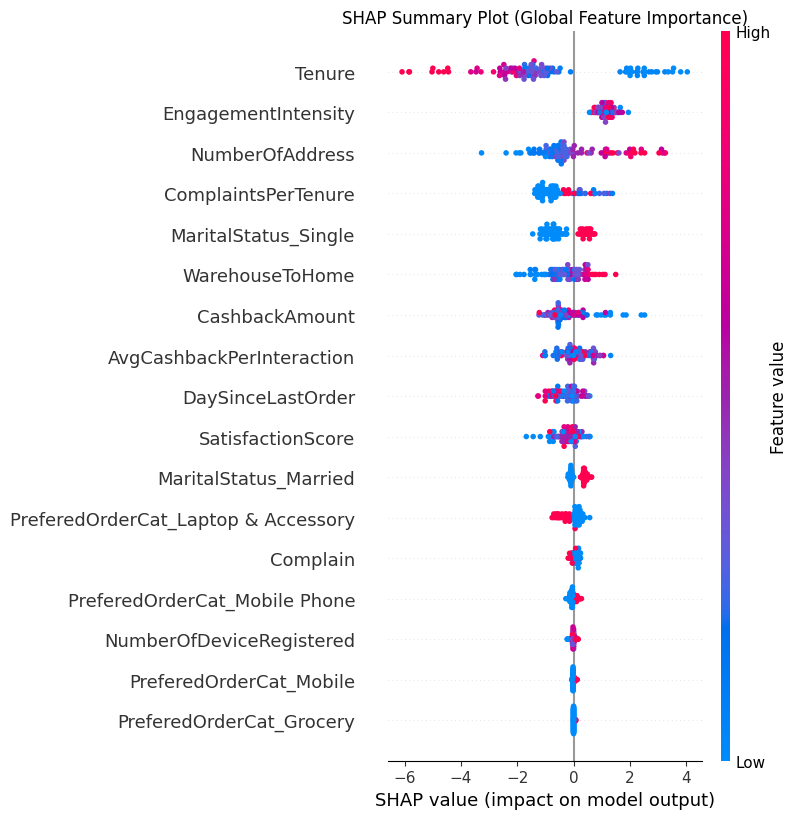

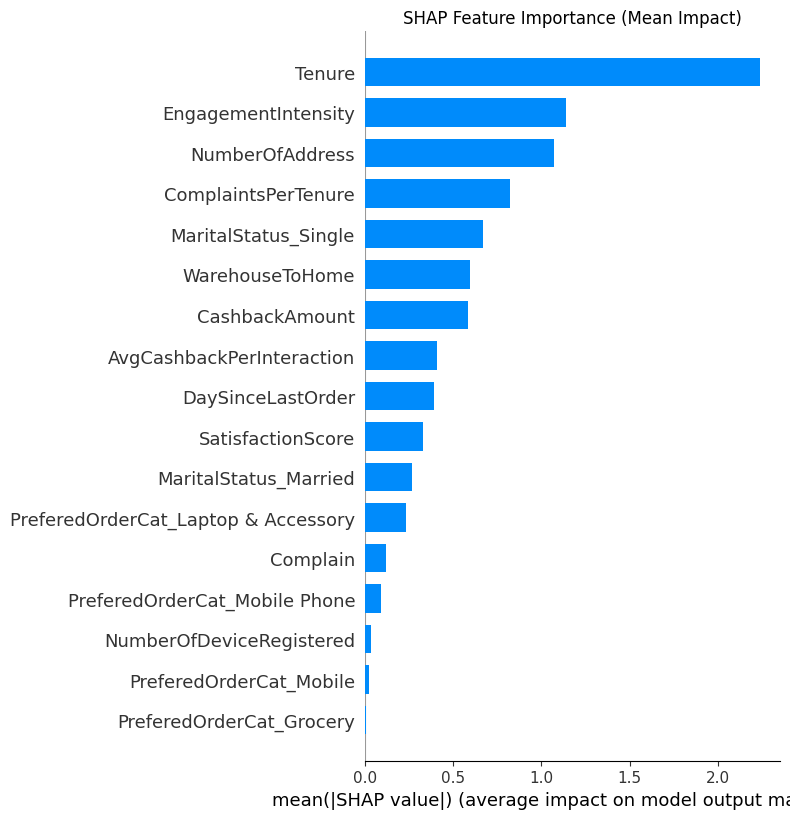

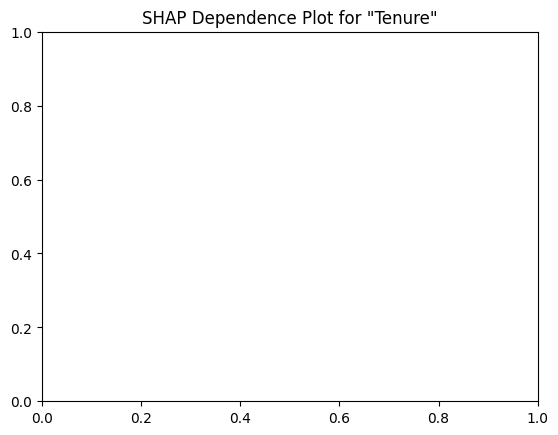

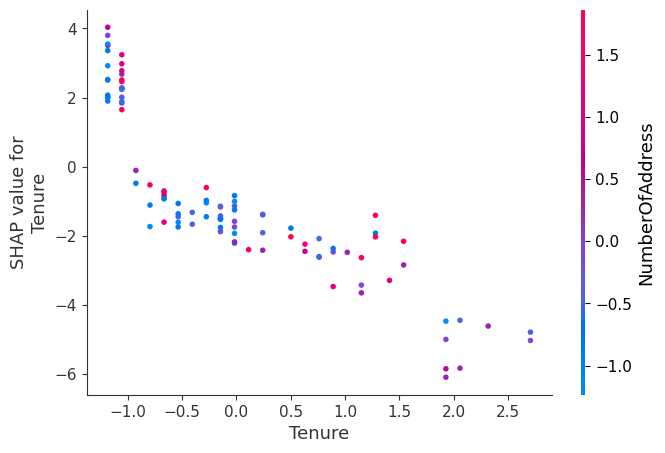

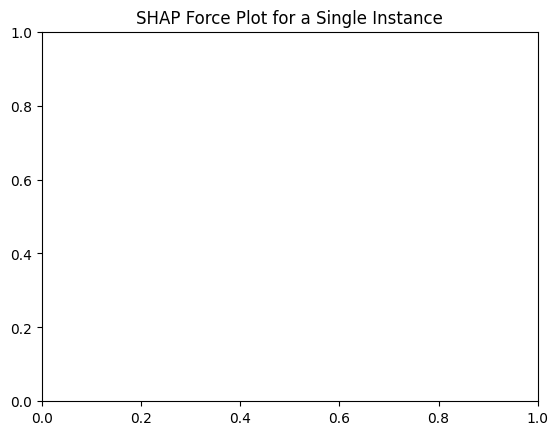

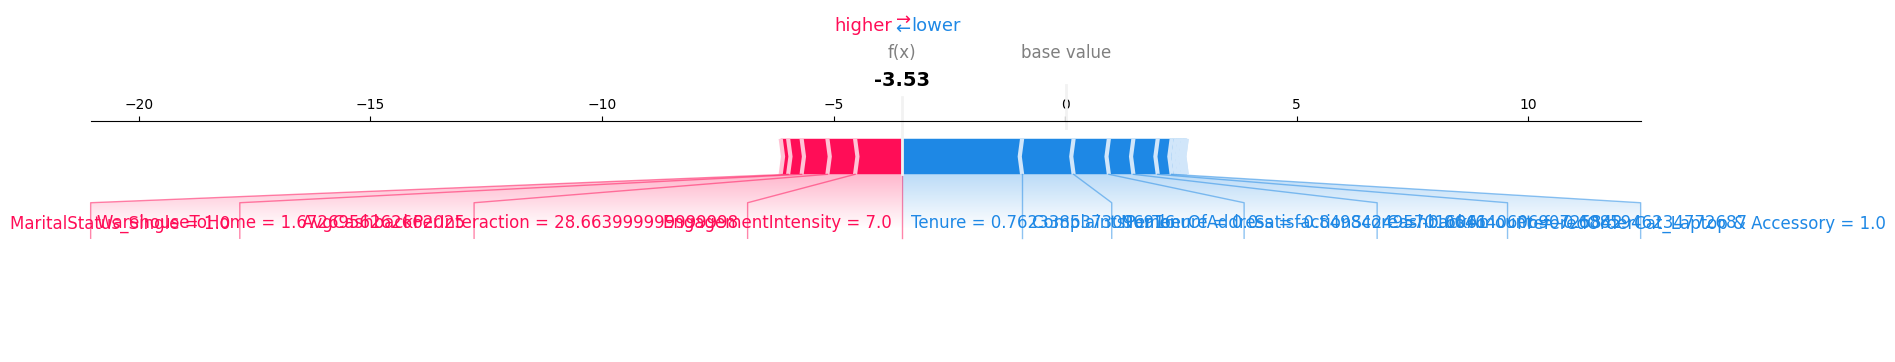

In [41]:
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt

# Step 1: Load Dataset and Prepare Features
# Load the cleaned and preprocessed dataset (assumed to be `df_encoded` here)
df = pd.read_csv('data_ecommerce_customer_churn.csv')

# Step 2: Handle Missing Values and Encoding Categorical Variables
# Handle missing values in numerical columns
numerical_columns = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']
for column in numerical_columns:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# Step 3: Remove Outliers (if applicable)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in numerical_columns + ['CashbackAmount', 'NumberOfDeviceRegistered', 'NumberOfAddress']:
    df = remove_outliers(df, column)

# Step 4: Encode Categorical Variables
categorical_columns = ['PreferedOrderCat', 'MaritalStatus']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Step 5: Create Derived Features as Done During Training
# Derived Features
df_encoded['AvgCashbackPerInteraction'] = df_encoded['CashbackAmount'] / (df_encoded['NumberOfDeviceRegistered'] + 1)
df_encoded['ComplaintsPerTenure'] = df_encoded['Complain'] / (df_encoded['Tenure'] + 1)
df_encoded['EngagementIntensity'] = df_encoded['NumberOfDeviceRegistered'] + df_encoded['SatisfactionScore'] + df_encoded['Complain']

# Step 6: Feature Scaling (Standardization)
from sklearn.preprocessing import StandardScaler
features_to_scale = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 
                     'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount', 'SatisfactionScore']
scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

# Step 7: Load the Trained Model and Get Expected Feature Names
loaded_model = joblib.load('best_churn_model_xgb.pkl')

# Retrieve the expected feature names from the model
expected_feature_names = loaded_model.get_booster().feature_names

# Step 8: Ensure that the Data Contains All Expected Features in the Correct Order
# Align `df_encoded` with the model's expected features
X_final = df_encoded[expected_feature_names]

# Step 9: Ensure All Columns Are Numeric
X_final = X_final.apply(pd.to_numeric, errors='coerce')
X_final.fillna(0, inplace=True)

# Step 10: Use a Subset of Rows for SHAP Analysis (e.g., first 100 rows)
X_subset = X_final.head(100)  # Using a smaller subset for easier processing

# Step 11: Use SHAP to Explain the Model
# Using TreeExplainer specifically for XGBoost models
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X_subset)

# Step 12: Global Feature Importance - Summary Plot
# This plot shows the overall importance of each feature
plt.title('SHAP Summary Plot (Global Feature Importance)')
shap.summary_plot(shap_values, X_subset)

# Step 13: Detailed SHAP Value Plots
# a. SHAP Bar Plot - shows the mean absolute SHAP value for each feature
plt.title('SHAP Feature Importance (Mean Impact)')
shap.summary_plot(shap_values, X_subset, plot_type="bar")

# b. SHAP Dependence Plot - shows how a feature value impacts the prediction
# You can change 'Tenure' to any other feature you are interested in
plt.title('SHAP Dependence Plot for "Tenure"')
shap.dependence_plot('Tenure', shap_values, X_subset)

# Step 14: Local Interpretation with SHAP - Single Prediction Explanation
# Select a specific row (e.g., first customer) to explain the prediction
row_to_explain = 0
shap.initjs()
plt.title('SHAP Force Plot for a Single Instance')
shap.force_plot(explainer.expected_value, shap_values[row_to_explain], X_subset.iloc[row_to_explain], matplotlib=True)